<h1>LSTM</h1>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import tokenizer_from_json

import json
import os

# Wczytanie danych
df = pd.read_csv(r"C:\Users\User\PycharmProjects\sentiment\finaldata\przefiltrowanebezprezydentapowinnobycok.csv")

# Podział na train/test
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["sentiment"], test_size=0.2, random_state=42, stratify=df["sentiment"])

# Mapowanie etykiet (0, 2, 4 → 0, 1, 2)
y_train_mapped = y_train.map({0: 0, 2: 1, 4: 2})
y_test_mapped = y_test.map({0: 0, 2: 1, 4: 2})

# Tokenizacja i zamiana tekstu na sekwencje liczbowych tokenów
MAX_WORDS = 20000
MAX_LEN = 100
EMBEDDING_DIM = 100  # Dopasowane do GloVe

save_path = r"C:\Users\User\PycharmProjects\sentiment\models\zlozone"
os.makedirs(save_path, exist_ok=True)
tokenizer_path = os.path.join(save_path, "tokenizer.json")

if os.path.exists(tokenizer_path):
    with open(tokenizer_path, "r") as f:
        tokenizer_json = json.load(f)
        tokenizer = tokenizer_from_json(tokenizer_json)
    print("✅ Wczytano zapisany tokenizer.")
else:
    tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)
    tokenizer_json = tokenizer.to_json()
    with open(tokenizer_path, "w") as f:
        json.dump(tokenizer_json, f)
    print("✅ Tokenizer został utworzony i zapisany.")

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Wczytanie embeddingu GloVe
embedding_index = {}
with open(r"C:\Users\User\PycharmProjects\sentiment\notebooks\glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < MAX_WORDS:
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

# Budowa modelu
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False),  
    
    Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2, dropout=0.2)),
    BatchNormalization(),
    Dropout(0.2),
    
    Bidirectional(LSTM(64, recurrent_dropout=0.2, dropout=0.2)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),
    
    Dense(3, activation="softmax")  
])

# Kompilacja modelu
optimizer = Adam(learning_rate=0.0005)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Callbacki
best_model_path = os.path.join(save_path, "lstm_best_model.h5")

checkpoint_callback = ModelCheckpoint(
    best_model_path,
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

early_stop_callback = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Trenowanie modelu
with tf.device('/GPU:0'):
    history = model.fit(
        X_train_pad, y_train_mapped,
        epochs=20, batch_size=128,
        validation_data=(X_test_pad, y_test_mapped),
        callbacks=[checkpoint_callback, early_stop_callback, reduce_lr_callback]
    )

# Ewaluacja modelu
y_pred = np.argmax(model.predict(X_test_pad), axis=1)
accuracy = accuracy_score(y_test_mapped, y_pred)
print(f"\n🔹 **Dokładność modelu LSTM: {accuracy:.4f}**\n")
print("🔹 **Raport klasyfikacji:**")
print(classification_report(y_test_mapped, y_pred))

# Macierz konfuzji
cm = confusion_matrix(y_test_mapped, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Negatywny", "Neutralny", "Pozytywny"], yticklabels=["Negatywny", "Neutralny", "Pozytywny"])
plt.xlabel("Przewidywane")
plt.ylabel("Prawdziwe")
plt.title("🔹 Macierz konfuzji - LSTM")
plt.show()

# Zapis modelu
model.save(os.path.join(save_path, "lstm_model_final1.h5"))
print("\n✅ **Model LSTM i tokenizer zapisane poprawnie!**")


✅ Wczytano zapisany tokenizer.


C:\Users\User\miniconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.5095 - loss: 1.5383   
Epoch 1: val_loss improved from inf to 0.83316, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1125s 993ms/step - accuracy: 0.5095 - loss: 1.5380 - val_accuracy: 0.6544 - val_loss: 0.8332 - learning_rate: 5.0000e-04
Epoch 2/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.6459 - loss: 0.8301   
Epoch 2: val_loss improved from 0.83316 to 0.74283, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1076s 959ms/step - accuracy: 0.6459 - loss: 0.8301 - val_accuracy: 0.6814 - val_loss: 0.7428 - learning_rate: 5.0000e-04
Epoch 3/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 0.6729 - loss: 0.7574   
Epoch 3: val_loss improved from 0.74283 to 0.70335, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1096s 977ms/step - accuracy: 0.6729 - loss: 0.7573 - val_accuracy: 0.7027 - val_loss: 0.7033 - learning_rate: 5.0000e-04
Epoch 4/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 948ms/step - accuracy: 0.6891 - loss: 0.7285   
Epoch 4: val_loss improved from 0.70335 to 0.68392, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1104s 984ms/step - accuracy: 0.6891 - loss: 0.7285 - val_accuracy: 0.7107 - val_loss: 0.6839 - learning_rate: 5.0000e-04
Epoch 5/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.6989 - loss: 0.7086   
Epoch 5: val_loss improved from 0.68392 to 0.66974, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1117s 996ms/step - accuracy: 0.6989 - loss: 0.7086 - val_accuracy: 0.7180 - val_loss: 0.6697 - learning_rate: 5.0000e-04
Epoch 6/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 978ms/step - accuracy: 0.7068 - loss: 0.6945   
Epoch 6: val_loss improved from 0.66974 to 0.66241, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1140s 1s/step - accuracy: 0.7068 - loss: 0.6945 - val_accuracy: 0.7222 - val_loss: 0.6624 - learning_rate: 5.0000e-04
Epoch 7/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.7124 - loss: 0.6834   
Epoch 7: val_loss improved from 0.66241 to 0.65678, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1152s 1s/step - accuracy: 0.7124 - loss: 0.6834 - val_accuracy: 0.7223 - val_loss: 0.6568 - learning_rate: 5.0000e-04
Epoch 8/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.7194 - loss: 0.6715   
Epoch 8: val_loss improved from 0.65678 to 0.65205, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1156s 1s/step - accuracy: 0.7194 - loss: 0.6715 - val_accuracy: 0.7251 - val_loss: 0.6520 - learning_rate: 5.0000e-04
Epoch 9/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7218 - loss: 0.6613       
Epoch 9: val_loss improved from 0.65205 to 0.64196, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1168s 1s/step - accuracy: 0.7218 - loss: 0.6613 - val_accuracy: 0.7297 - val_loss: 0.6420 - learning_rate: 5.0000e-04
Epoch 10/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7253 - loss: 0.6583       
Epoch 10: val_loss improved from 0.64196 to 0.63697, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1175s 1s/step - accuracy: 0.7253 - loss: 0.6583 - val_accuracy: 0.7331 - val_loss: 0.6370 - learning_rate: 5.0000e-04
Epoch 11/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7299 - loss: 0.6466   
Epoch 11: val_loss did not improve from 0.63697
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1181s 1s/step - accuracy: 0.7299 - loss: 0.6466 - val_accuracy: 0.7323 - val_loss: 0.6396 - learning_rate: 5.0000e-04
Epoch 12/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7323 - loss: 0.6426   
Epoch 12: val_loss improved from 0.63697 to 0.63532, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1198s 1s/step - accuracy: 0.7323 - loss: 0.6426 - val_accuracy: 0.7339 - val_loss: 0.6353 - learning_rate: 5.0000e-04
Epoch 13/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7361 - loss: 0.6354   
Epoch 13: val_loss improved from 0.63532 to 0.63042, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1201s 1s/step - accuracy: 0.7361 - loss: 0.6354 - val_accuracy: 0.7353 - val_loss: 0.6304 - learning_rate: 5.0000e-04
Epoch 14/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7366 - loss: 0.6339   
Epoch 14: val_loss did not improve from 0.63042
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1204s 1s/step - accuracy: 0.7366 - loss: 0.6339 - val_accuracy: 0.7341 - val_loss: 0.6333 - learning_rate: 5.0000e-04
Epoch 15/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7366 - loss: 0.6336   
Epoch 15: val_loss improved from 0.63042 to 0.62853, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1218s 1s/step - accuracy: 0.7366 - loss: 0.6336 - val_accuracy: 0.7371 - val_loss: 0.6285 - learning_rate: 5.0000e-04
Epoch 16/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7398 - loss: 0.6241   
Epoch 16: val_loss did not improve from 0.62853
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1230s 1s/step - accuracy: 0.7398 - loss: 0.6241 - val_accuracy: 0.7365 - val_loss: 0.6320 - learning_rate: 5.0000e-04
Epoch 17/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7379 - loss: 0.6260   
Epoch 17: val_loss did not improve from 0.62853

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1241s 1s/step - accuracy: 0.7379 - loss: 0.6260 - val_accuracy: 0.7369 - val_loss: 0.6336 - learning_rate: 5.0000e-04
Epoch 18/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7456 - loss: 0.6109   
Epoch 18: val_loss improved from 0.62853 to 0.62567, saving model to C:\Users\User\PycharmProjects\sentime

1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1234s 1s/step - accuracy: 0.7456 - loss: 0.6109 - val_accuracy: 0.7383 - val_loss: 0.6257 - learning_rate: 2.5000e-04
Epoch 19/20
 718/1122 ━━━━━━━━━━━━━━━━━━━━ 7:09 1s/step - accuracy: 0.7466 - loss: 0.6065 

<h1>CNN</h1>

Epoch 1/20
1122/1122 [==============================] - ETA: 0s - loss: 1.3341 - accuracy: 0.4959   
Epoch 1: val_loss improved from inf to 0.95535, saving model to C:\Users\User\PycharmProjects\sentiment\models\cnn\cnn_best_model.h5
1122/1122 [==============================] - 115s 101ms/step - loss: 1.3341 - accuracy: 0.4959 - val_loss: 0.9554 - val_accuracy: 0.6046 - lr: 0.0010
Epoch 2/20
   1/1122 [..............................] - ETA: 1:40 - loss: 0.8701 - accuracy: 0.5781

C:\Users\User\miniconda3\envs\tf_env\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1122/1122 [==============================] - ETA: 0s - loss: 0.7444 - accuracy: 0.7038  
Epoch 2: val_loss improved from 0.95535 to 0.69541, saving model to C:\Users\User\PycharmProjects\sentiment\models\cnn\cnn_best_model.h5
1122/1122 [==============================] - 111s 99ms/step - loss: 0.7444 - accuracy: 0.7038 - val_loss: 0.6954 - val_accuracy: 0.7269 - lr: 0.0010
Epoch 3/20
1122/1122 [==============================] - ETA: 0s - loss: 0.6073 - accuracy: 0.7593  
Epoch 3: val_loss improved from 0.69541 to 0.66627, saving model to C:\Users\User\PycharmProjects\sentiment\models\cnn\cnn_best_model.h5
1122/1122 [==============================] - 113s 100ms/step - loss: 0.6073 - accuracy: 0.7593 - val_loss: 0.6663 - val_accuracy: 0.7270 - lr: 0.0010
Epoch 4/20
1122/1122 [==============================] - ETA: 0s - loss: 0.5480 - accuracy: 0.7847  
Epoch 4: val_loss did not improve from 0.66627
1122/1122 [==============================] - 111s 99ms/step - loss: 0.5480 - accuracy: 0.78

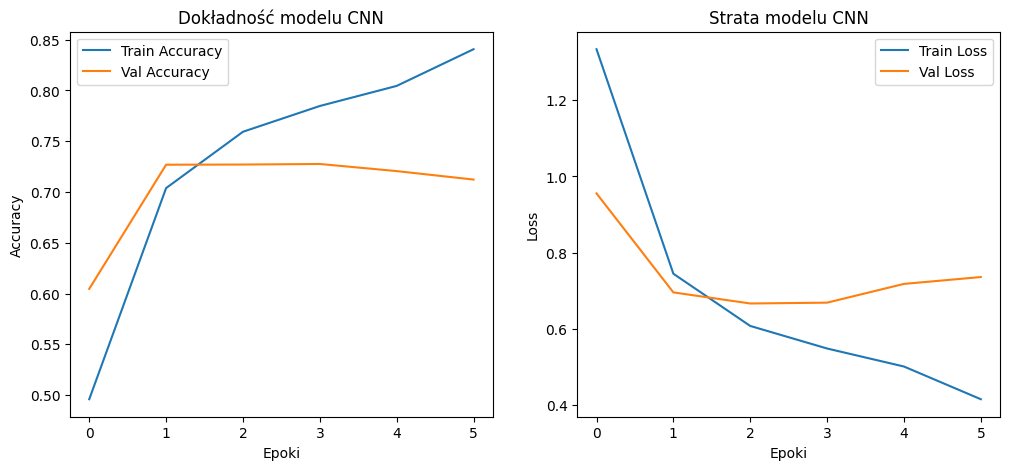

1122/1122 [==============================] - 6s 5ms/step

🔹 **Dokładność modelu CNN: 0.7270**

🔹 **Raport klasyfikacji:**
              precision    recall  f1-score   support

           0       0.65      0.78      0.71     11890
           1       0.86      0.74      0.79     11953
           2       0.70      0.66      0.68     12056

    accuracy                           0.73     35899
   macro avg       0.74      0.73      0.73     35899
weighted avg       0.74      0.73      0.73     35899



C:\Users\User\miniconda3\envs\tf_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


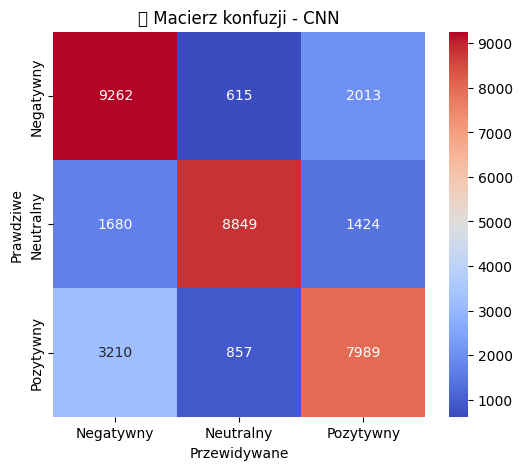

C:\Users\User\miniconda3\envs\tf_env\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



✅ **Model CNN i tokenizer zapisane poprawnie!**


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import json
import os

# Wczytanie danych
df = pd.read_csv(r"C:\Users\User\PycharmProjects\sentiment\finaldata\przefiltrowanebezprezydentapowinnobycok.csv")


X_train, X_test, y_train, y_test = train_test_split(df["text"], df["sentiment"], test_size=0.2, random_state=42)


y_train_mapped = y_train.map({0: 0, 2: 1, 4: 2})
y_test_mapped = y_test.map({0: 0, 2: 1, 4: 2})

# Tokenizacja i zamiana tekstu na sekwencje liczbowych tokenów
MAX_WORDS = 20000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Budowa modelu CNN
EMBEDDING_DIM = 128
LEARNING_RATE = 0.001

model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),  

    Conv1D(128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Conv1D(64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    GlobalMaxPooling1D(),

    Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.4),

    Dense(3, activation="softmax")  
])

# Kompilacja modelu
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

#Callbacki
save_path = r"C:\Users\User\PycharmProjects\sentiment\models\cnn"
os.makedirs(save_path, exist_ok=True)

best_model_path = os.path.join(save_path, "cnn_best_model.h5")

checkpoint_callback = ModelCheckpoint(
    best_model_path,
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

early_stop_callback = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Trenowanie modelu
history = model.fit(
    X_train_pad, y_train_mapped,
    epochs=20, batch_size=128,
    validation_data=(X_test_pad, y_test_mapped),
    callbacks=[checkpoint_callback, early_stop_callback, reduce_lr_callback]
)

#Najlepsza epoka
best_epoch = np.argmin(history.history["val_loss"]) + 1
print(f"\n🏆 **Najlepsza epoka:** {best_epoch}")

#Wizualizacja wyników
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoki')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Dokładność modelu CNN')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoki')
plt.ylabel('Loss')
plt.legend()
plt.title('Strata modelu CNN')

plt.savefig(os.path.join(save_path, "training_plot.png"))
plt.show()

#Ewaluacja modelu
y_pred = np.argmax(model.predict(X_test_pad), axis=1)
accuracy = accuracy_score(y_test_mapped, y_pred)
print(f"\n **Dokładność modelu CNN: {accuracy:.4f}**\n")
print(" **Raport klasyfikacji:**")
print(classification_report(y_test_mapped, y_pred))

#Macierz konfuzji
cm = confusion_matrix(y_test_mapped, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Negatywny", "Neutralny", "Pozytywny"], yticklabels=["Negatywny", "Neutralny", "Pozytywny"])
plt.xlabel("Przewidywane")
plt.ylabel("Prawdziwe")
plt.title(" Macierz konfuzji - CNN")
plt.show()

# Zapis modelu i tokenizera
model.save(os.path.join(save_path, "cnn_model_final.h5"))

# Tokenizer
tokenizer_json = tokenizer.to_json()
with open(os.path.join(save_path, "tokenizer.json"), "w") as f:
    json.dump(tokenizer_json, f)

print("\n✅ **Model CNN i tokenizer zapisane poprawnie!**")


<h1>ULMFiT</h1>

In [2]:
import pandas as pd
from fastai.text.all import *
from sklearn.model_selection import train_test_split
from fastai.callback.tracker import SaveModelCallback

import os

df = pd.read_csv(r"C:\Users\User\PycharmProjects\sentiment\finaldata\przefiltrowanebezprezydentapowinnobycok.csv")

#Mapowanie etykiet (0, 2, 4 → 0, 1, 2)
df["sentiment"] = df["sentiment"].map({0: 0, 2: 1, 4: 2})

#Podział na train/test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Tworzenie DataLoaders (z `num_workers=0` na Windowsie)
dls = TextDataLoaders.from_df(df_train, text_col="text", label_col="sentiment", valid_pct=0.2, bs=64, num_workers=0)

#Budowa modelu ULMFiT
learn = text_classifier_learner(dls, AWD_LSTM, metrics=accuracy)

# Dodanie callbacków:
# - SaveModelCallback → zapisuje najlepszy model
# - EarlyStoppingCallback → zatrzymuje trening, jeśli nie ma poprawy
callbacks = [
    SaveModelCallback(monitor="valid_loss", fname="best_ulmfit", comp=np.less),  # Poprawiona kolejność argumentów
    EarlyStoppingCallback(monitor="valid_loss", patience=3)  # Kolejność poprawna
]

# Trening modelu (FastAI sam wybierze najlepszą epokę)
learn.fine_tune(10, cbs=callbacks)

# Wczytanie najlepszego modelu
learn.load("best_ulmfit")

# Ewaluacja modelu
accuracy = learn.validate()[1]
print(f"\n🏆 **Najlepsza dokładność modelu ULMFiT: {accuracy:.4f}**\n")

# Zapis najlepszego modelu
save_path = r"C:\Users\User\PycharmProjects\sentiment\models\ulmfit"
os.makedirs(save_path, exist_ok=True)
learn.export(os.path.join(save_path, "best_ulmfit.pkl"))

print("\n✅ **Najlepsza epoka modelu ULMFiT zapisana poprawnie!**")


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


C:\Users\User\miniconda3\envs\tf_env\lib\site-packages\fastai\text\learner.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wgts = torch.load(wgts_fname, map_location =

epoch,train_loss,valid_loss,accuracy,time
0,0.964754,0.891612,0.581621,06:55


Better model found at epoch 0 with valid_loss value: 0.8916119933128357.


C:\Users\User\miniconda3\envs\tf_env\lib\site-packages\fastai\text\learner.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device)

epoch,train_loss,valid_loss,accuracy,time
0,0.845180,0.764028,0.664218,16:31
1,0.778953,0.709325,0.700153,16:18
2,0.755289,0.684955,0.710182,16:17
3,0.701189,0.666219,0.721603,16:13
4,0.692471,0.660445,0.722543,16:24
5,0.686871,0.649305,0.730134,16:21
6,0.651210,0.644977,0.732224,16:17
7,0.622764,0.648312,0.731910,16:22
8,0.622212,0.646455,0.732746,16:20
9,0.611306,0.654103,0.732015,16:22


Better model found at epoch 0 with valid_loss value: 0.7640281319618225.
Better model found at epoch 1 with valid_loss value: 0.7093247771263123.
Better model found at epoch 2 with valid_loss value: 0.6849550604820251.
Better model found at epoch 3 with valid_loss value: 0.6662194728851318.
Better model found at epoch 4 with valid_loss value: 0.6604450345039368.
Better model found at epoch 5 with valid_loss value: 0.6493046283721924.
Better model found at epoch 6 with valid_loss value: 0.6449774503707886.
No improvement since epoch 6: early stopping


C:\Users\User\miniconda3\envs\tf_env\lib\site-packages\fastai\text\learner.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device)


🏆 **Najlepsza dokładność modelu ULMFiT: 0.7322**


✅ **Najlepsza epoka modelu ULMFiT zapisana poprawnie!**


✅ Wczytano zapisany tokenizer.


C:\Users\User\miniconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5197 - loss: 1.4754      
Epoch 1: val_loss improved from inf to 0.81800, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_eval_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1193s 1s/step - accuracy: 0.5198 - loss: 1.4751 - val_accuracy: 0.6593 - val_loss: 0.8180 - learning_rate: 5.0000e-04
Epoch 2/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - accuracy: 0.6474 - loss: 0.8169   
Epoch 2: val_loss improved from 0.81800 to 0.72649, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_eval_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1147s 1s/step - accuracy: 0.6474 - loss: 0.8169 - val_accuracy: 0.6892 - val_loss: 0.7265 - learning_rate: 5.0000e-04
Epoch 3/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - accuracy: 0.6721 - loss: 0.7598    
Epoch 3: val_loss improved from 0.72649 to 0.69640, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_eval_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1145s 1s/step - accuracy: 0.6721 - loss: 0.7598 - val_accuracy: 0.7063 - val_loss: 0.6964 - learning_rate: 5.0000e-04
Epoch 4/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.6917 - loss: 0.7234    
Epoch 4: val_loss improved from 0.69640 to 0.69547, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_eval_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1146s 1s/step - accuracy: 0.6917 - loss: 0.7234 - val_accuracy: 0.7023 - val_loss: 0.6955 - learning_rate: 5.0000e-04
Epoch 5/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - accuracy: 0.7005 - loss: 0.7075   
Epoch 5: val_loss improved from 0.69547 to 0.67280, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_eval_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1161s 1s/step - accuracy: 0.7005 - loss: 0.7075 - val_accuracy: 0.7165 - val_loss: 0.6728 - learning_rate: 5.0000e-04
Epoch 6/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7085 - loss: 0.6911   
Epoch 6: val_loss improved from 0.67280 to 0.66319, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_eval_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1181s 1s/step - accuracy: 0.7085 - loss: 0.6911 - val_accuracy: 0.7221 - val_loss: 0.6632 - learning_rate: 5.0000e-04
Epoch 7/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7130 - loss: 0.6783   
Epoch 7: val_loss did not improve from 0.66319
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1189s 1s/step - accuracy: 0.7130 - loss: 0.6783 - val_accuracy: 0.7231 - val_loss: 0.6634 - learning_rate: 5.0000e-04
Epoch 8/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7186 - loss: 0.6729   
Epoch 8: val_loss improved from 0.66319 to 0.65837, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_eval_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1167s 1s/step - accuracy: 0.7186 - loss: 0.6729 - val_accuracy: 0.7259 - val_loss: 0.6584 - learning_rate: 5.0000e-04
Epoch 9/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7226 - loss: 0.6637   
Epoch 9: val_loss improved from 0.65837 to 0.64983, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_eval_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1179s 1s/step - accuracy: 0.7226 - loss: 0.6637 - val_accuracy: 0.7267 - val_loss: 0.6498 - learning_rate: 5.0000e-04
Epoch 10/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7267 - loss: 0.6571   
Epoch 10: val_loss improved from 0.64983 to 0.64146, saving model to C:\Users\User\PycharmProjects\sentiment\models\zlozone\lstm_eval_best_model.h5


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1184s 1s/step - accuracy: 0.7267 - loss: 0.6571 - val_accuracy: 0.7328 - val_loss: 0.6415 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 10.
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 88s 77ms/step 

🔹 **Dokładność modelu LSTM: 0.7328**

🔹 **Raport klasyfikacji:**
              precision    recall  f1-score   support

           0       0.68      0.75      0.71     11978
           1       0.90      0.72      0.80     11955
           2       0.67      0.72      0.69     11966

    accuracy                           0.73     35899
   macro avg       0.75      0.73      0.74     35899
weighted avg       0.75      0.73      0.74     35899



C:\Users\User\miniconda3\envs\tf_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


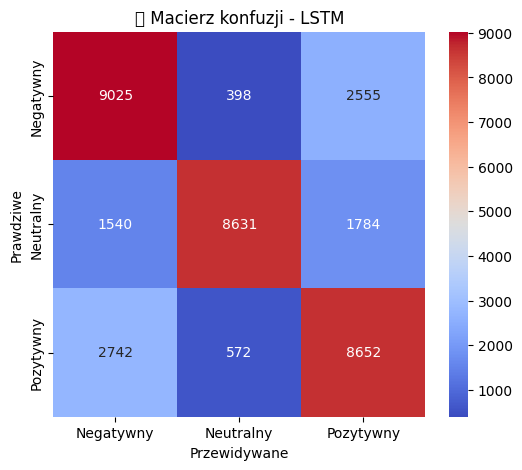


✅ **Model LSTM i tokenizer zapisane poprawnie!**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import tokenizer_from_json

import json
import os

# Wczytanie danych
df = pd.read_csv(r"C:\Users\User\PycharmProjects\sentiment\finaldata\przefiltrowanebezprezydentapowinnobycok.csv")

# Podział na train/test
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["sentiment"], test_size=0.2, random_state=42, stratify=df["sentiment"])

# Mapowanie etykiet (0, 2, 4 → 0, 1, 2)
y_train_mapped = y_train.map({0: 0, 2: 1, 4: 2})
y_test_mapped = y_test.map({0: 0, 2: 1, 4: 2})

# Tokenizacja i zamiana tekstu na sekwencje liczbowych tokenów
MAX_WORDS = 20000
MAX_LEN = 100
EMBEDDING_DIM = 100  # Dopasowane do GloVe

save_path = r"C:\Users\User\PycharmProjects\sentiment\models\zlozone"
os.makedirs(save_path, exist_ok=True)
tokenizer_path = os.path.join(save_path, "tokenizer.json")

if os.path.exists(tokenizer_path):
    with open(tokenizer_path, "r") as f:
        tokenizer_json = json.load(f)
        tokenizer = tokenizer_from_json(tokenizer_json)
    print("✅ Wczytano zapisany tokenizer.")
else:
    tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)
    tokenizer_json = tokenizer.to_json()
    with open(tokenizer_path, "w") as f:
        json.dump(tokenizer_json, f)
    print("✅ Tokenizer został utworzony i zapisany.")

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Wczytanie embeddingu GloVe
embedding_index = {}
with open(r"C:\Users\User\PycharmProjects\sentiment\notebooks\glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < MAX_WORDS:
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

# Budowa modelu
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False),

    Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2, dropout=0.2)),
    BatchNormalization(),
    Dropout(0.2),

    Bidirectional(LSTM(64, recurrent_dropout=0.2, dropout=0.2)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),

    Dense(3, activation="softmax")
])

# Kompilacja modelu
optimizer = Adam(learning_rate=0.0005)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Callbacki
best_model_path = os.path.join(save_path, "lstm_eval_best_model.h5")

checkpoint_callback = ModelCheckpoint(
    best_model_path,
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

early_stop_callback = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Trenowanie modelu (tu zmieniono epochs=10)
with tf.device('/GPU:0'):
    history = model.fit(
        X_train_pad, y_train_mapped,
        epochs=10,  # <---- liczba epok zmieniona na 10
        batch_size=128,
        validation_data=(X_test_pad, y_test_mapped),
        callbacks=[checkpoint_callback, early_stop_callback, reduce_lr_callback]
    )

# Ewaluacja modelu
y_pred = np.argmax(model.predict(X_test_pad), axis=1)
accuracy = accuracy_score(y_test_mapped, y_pred)
print(f"\n🔹 **Dokładność modelu LSTM: {accuracy:.4f}**\n")
print("🔹 **Raport klasyfikacji:**")
print(classification_report(y_test_mapped, y_pred))

# Macierz konfuzji
cm = confusion_matrix(y_test_mapped, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm",
            xticklabels=["Negatywny", "Neutralny", "Pozytywny"],
            yticklabels=["Negatywny", "Neutralny", "Pozytywny"])
plt.xlabel("Przewidywane")
plt.ylabel("Prawdziwe")
plt.title("🔹 Macierz konfuzji - LSTM")
plt.show()

# Zapis modelu
model.save(os.path.join(save_path, "lstm_model_finaal1.h5"))
print("\n✅ **Model LSTM i tokenizer zapisane poprawnie!**")
